# Creating a mini map using homography transformations

Author Stephan Janssen (sja@devoxx.com)

See also related article on LinkedIn.

We still need to identify the players per team which can be achieved using colour detection, that's not too difficult.

What I currently don't know is how to transform the players positions (tensor pred_boxes) from the 3D image and transform them onto the 2D court image.

Suggestions are welcome!



# Install detectron2

In [4]:
# install dependencies
!pip install -U torch torchvision cython
!pip install -U 'git+https://github.com/facebookresearch/fvcore.git' 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
torch.__version__

Requirement already up-to-date: torch in /usr/local/lib/python3.6/dist-packages (1.3.1)
Requirement already up-to-date: torchvision in /usr/local/lib/python3.6/dist-packages (0.4.2)
Requirement already up-to-date: cython in /usr/local/lib/python3.6/dist-packages (0.29.14)
  Cloning https://github.com/facebookresearch/fvcore.git to /tmp/pip-req-build-znd0djgv
  Running command git clone -q https://github.com/facebookresearch/fvcore.git /tmp/pip-req-build-znd0djgv
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-7w139vsz
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-7w139vsz
     |████████████████████████████████| 266kB 9.2MB/s 
  Created wheel for fvcore: filename=fvcore-0.1-cp36-none-any.whl size=34040 sha256=a42d32401f9e6fc1b54c87b376c911467bdef5fdbf06e82fe0f953acfc52f695
  Stored in directory: /tmp/pip-ephem-wheel-cache-t8i58qg6/wheels/48/53/79/3c6485543a4455a0006f5db590ab9957622b6227011941de06
  Created wheel f

'1.3.1'

In [5]:
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -e detectron2_repo

Cloning into 'detectron2_repo'...
remote: Enumerating objects: 46, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 1912 (delta 8), reused 14 (delta 8), pack-reused 1866
Receiving objects: 100% (1912/1912), 1.76 MiB | 3.17 MiB/s, done.
Resolving deltas: 100% (1194/1194), done.
Obtaining file:///content/detectron2_repo
     |████████████████████████████████| 2.1MB 6.6MB/s 
     |████████████████████████████████| 61kB 7.9MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 4.3.0
    Uninstalling Pillow-4.3.0:
      Successfully uninstalled Pillow-4.3.0
  Found existing installation: tqdm 4.28.1
    Uninstalling tqdm-4.28.1:
      Successfully uninstalled tqdm-4.28.1
  Running setup.py develop for detectron2


In [0]:
# You may need to restart your runtime prior to this, to let your installation take effect

# Some basic setup

# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

# Run a pre-trained detectron2 model

We first download a random image from the COCO dataset:

--2019-12-21 13:13:21--  https://basketball-ml.s3-eu-west-1.amazonaws.com/3DBasketballMiddleView.jpg
Resolving basketball-ml.s3-eu-west-1.amazonaws.com (basketball-ml.s3-eu-west-1.amazonaws.com)... 52.218.37.136
Connecting to basketball-ml.s3-eu-west-1.amazonaws.com (basketball-ml.s3-eu-west-1.amazonaws.com)|52.218.37.136|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 77867 (76K) [image/jpeg]
Saving to: ‘input.jpg’

input.jpg           100%[===================>]  76.04K  --.-KB/s    in 0.04s   

2019-12-21 13:13:21 (1.95 MB/s) - ‘input.jpg’ saved [77867/77867]



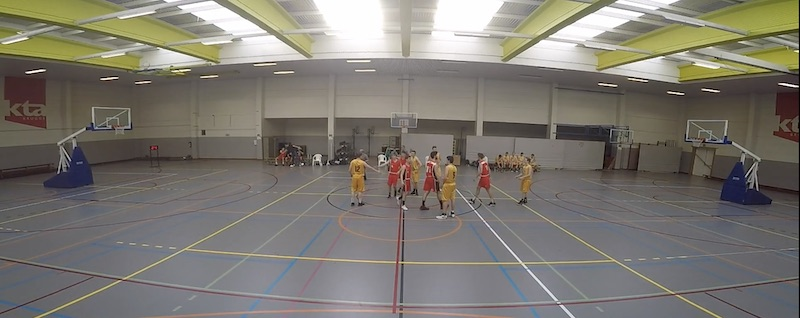

In [2]:
!wget https://basketball-ml.s3-eu-west-1.amazonaws.com/3DBasketballMiddleView.jpg -O input.jpg
im = cv2.imread("./input.jpg")
cv2_imshow(im)

Then, we create a detectron2 config and a detectron2 `DefaultPredictor` to run inference on this image.

In [3]:
cfg = get_cfg()

cfg.merge_from_file("./detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model

cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"

predictor = DefaultPredictor(cfg)

outputs = predictor(im)

WARNING [12/21 13:13:26 d2.config.compat]: Config './detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml' has no VERSION. Assuming it to be compatible with latest v2.


model_final_f10217.pkl: 178MB [00:17, 10.4MB/s]                           


In [4]:
# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
instances = outputs["instances"]
print(instances)
pred_boxes = instances.get("pred_boxes")
pred_classes = instances.get("pred_classes")
print(pred_boxes)
print(pred_classes)

Instances(num_instances=15, image_height=318, image_width=800, fields=[pred_boxes, scores, pred_classes, pred_masks])
Boxes(tensor([[347.9358, 151.1619, 368.8556, 207.0461],
        [471.2883, 152.9471, 496.2731, 206.3223],
        [514.9738, 155.6074, 535.5334, 205.0437],
        [437.9113, 153.9559, 458.1671, 218.7829],
        [385.8057, 153.7121, 402.7021, 199.6549],
        [419.9606, 151.7920, 441.7614, 210.5151],
        [407.7244, 149.3464, 421.8711, 197.4819],
        [396.0902, 153.9204, 412.6147, 208.2650],
        [274.3799, 145.1424, 287.9568, 165.4775],
        [496.4387, 153.1590, 503.2140, 171.7760],
        [503.1680, 151.6324, 510.2687, 171.2878],
        [312.1327, 153.0435, 322.8900, 166.7036],
        [510.4133, 154.2951, 519.2931, 172.9539],
        [685.2831, 119.0328, 728.6923, 144.6982],
        [528.8153, 153.3958, 538.0048, 173.2220]], device='cuda:0'))
tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 56,  0, 62,  0],
       device='cuda:0')


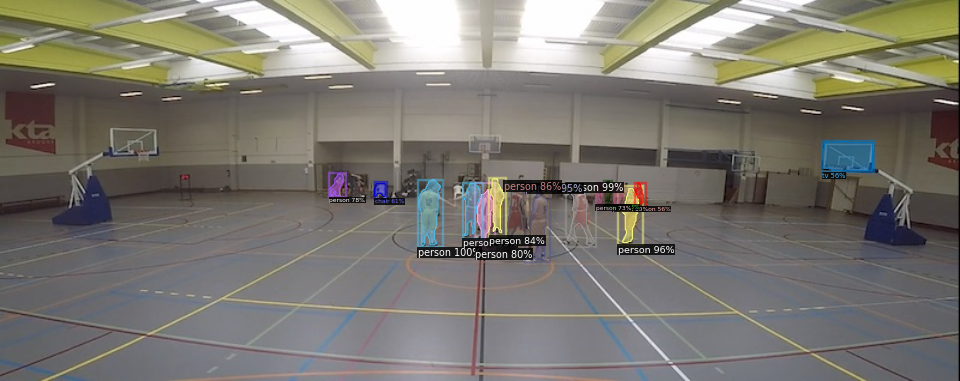

In [5]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

# Other types of builtin models

WARNING [12/21 09:28:12 d2.config.compat]: Config './detectron2_repo/configs/COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml' has no VERSION. Assuming it to be compatible with latest v2.


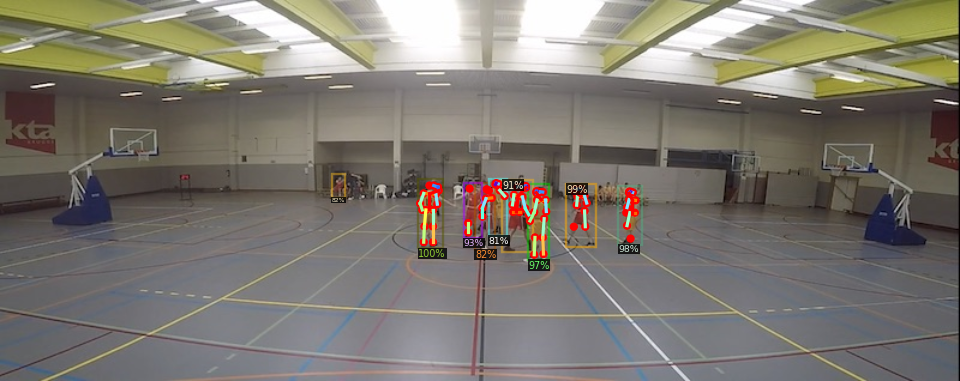

Instances(num_instances=9, image_height=318, image_width=800, fields=[pred_boxes, scores, pred_classes, pred_keypoints])


In [11]:
# Inference with a keypoint detection model
cfg = get_cfg()
cfg.merge_from_file("./detectron2_repo/configs/COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set threshold for this model
cfg.MODEL.WEIGHTS = "detectron2://COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x/137849621/model_final_a6e10b.pkl"
predictor = DefaultPredictor(cfg)
outputs = predictor(im)
v = Visualizer(im[:,:,::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

WARNING [12/21 09:26:08 d2.config.compat]: Config './detectron2_repo/configs/COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml' has no VERSION. Assuming it to be compatible with latest v2.


model_final_cafdb1.pkl: 261MB [00:04, 58.0MB/s]                           


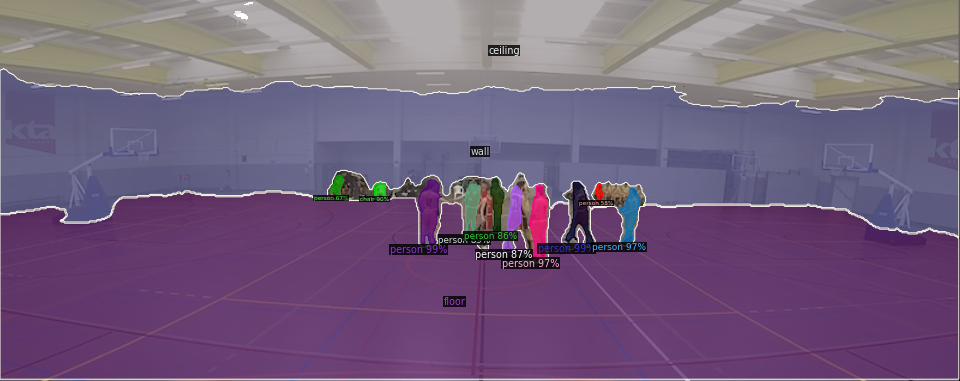

In [7]:
# Inference with a panoptic segmentation model
cfg = get_cfg()
cfg.merge_from_file("./detectron2_repo/configs/COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")
cfg.MODEL.WEIGHTS = "detectron2://COCO-PanopticSegmentation/panoptic_fpn_R_101_3x/139514519/model_final_cafdb1.pkl"
predictor = DefaultPredictor(cfg)
panoptic_seg, segments_info = predictor(im)["panoptic_seg"]
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)
cv2_imshow(v.get_image()[:, :, ::-1])

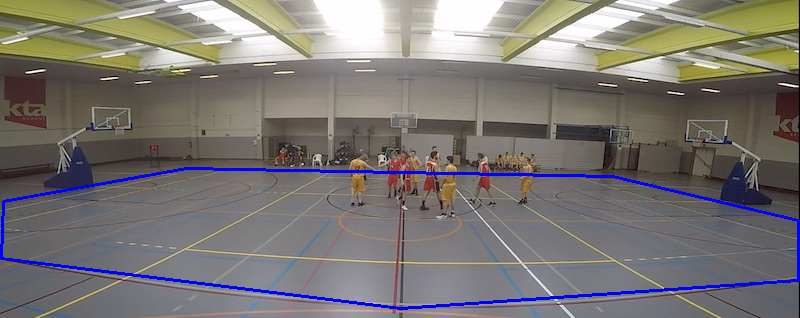

In [9]:
# Four corners of the 3D court + mid-court circle point in source image
# Start top-left corner and go anti-clock wise + mid-court circle point
src_pts = np.array([
    [1, 258],       # left bottom - bottom corner
    [400, 308],     # middle bottom corner
    [798, 280],     # right bottom - bottom corner
    [798, 220],     # right bottom - top corner
    [612, 176],     # top right rorner
    [186, 168],     # top left corner
    [3, 201]        # left bottom - top corner
    ])   

im_poly = im.copy()

# cv2.fillPoly(img_src, [src_pts], 255)
cv2.polylines(im_poly, [src_pts], isClosed=True, color=[255,0,0], thickness=2)

cv2_imshow(im_poly)

Player positions (x,y) :
[ 357,  207]
[ 483,  206]
[ 524,  205]
[ 447,  218]
[ 393,  199]
[ 430,  210]
[ 414,  197]
[ 404,  208]


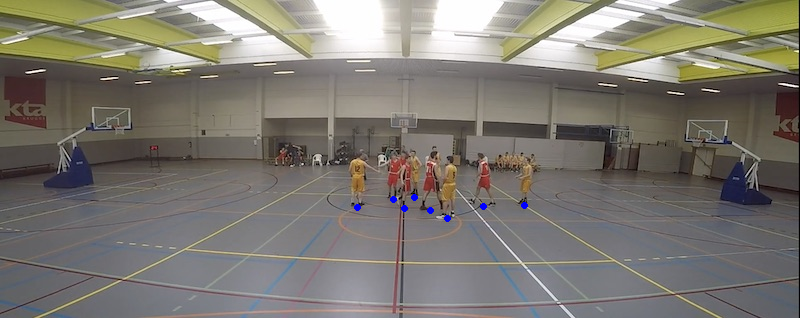

In [14]:
# Use the boxes info from the tensor prediction result
#
# x1,y1 ------
# |          |
# |          |
# |          |
# --------x2,y2
#
from shapely.geometry import Point, Polygon

color = [255, 0, 0]   
thickness = 2
radius = 2

print("Player positions (x,y) :")

i  = 0
for box in pred_boxes:
  
  # Include only class Person
  if pred_classes[i] == 0:  
      
    x1 = int(box[0])
    y1 = int(box[1])
    x2 = int(box[2])
    y2 = int(box[3])

    xc = x1 + int((x2 - x1)/2)
    player_pos = (xc, y2)

    court = Polygon(src_pts)

    # Draw only players that are within the basketball court
    if Point(player_pos).within(court):
      print("[% 3d, % 3d]" %(xc, y2))
      cv2.circle(im, player_pos, radius, color, thickness, lineType=8, shift=0)
    
    i = i + 1

cv2_imshow(im)

--2019-12-21 12:30:31--  https://basketball-ml.s3-eu-west-1.amazonaws.com/2DCourtBasketball.jpg
Resolving basketball-ml.s3-eu-west-1.amazonaws.com (basketball-ml.s3-eu-west-1.amazonaws.com)... 52.218.108.0
Connecting to basketball-ml.s3-eu-west-1.amazonaws.com (basketball-ml.s3-eu-west-1.amazonaws.com)|52.218.108.0|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34933 (34K) [image/jpeg]
Saving to: ‘court.jpg’

court.jpg           100%[===================>]  34.11K   133KB/s    in 0.3s    

2019-12-21 12:30:32 (133 KB/s) - ‘court.jpg’ saved [34933/34933]



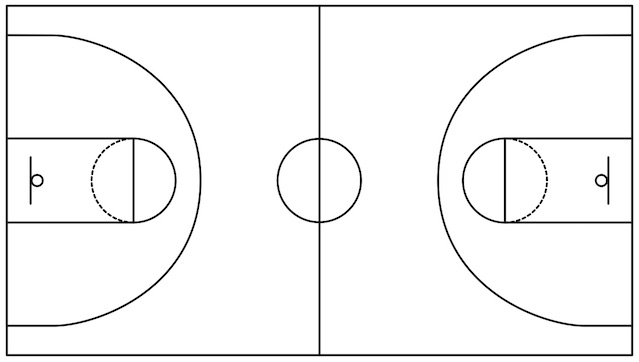

In [52]:
!wget https://basketball-ml.s3-eu-west-1.amazonaws.com/2DCourtBasketball.jpg -O court.jpg
img_dst = cv2.imread('./court.jpg')
cv2_imshow(img_dst)

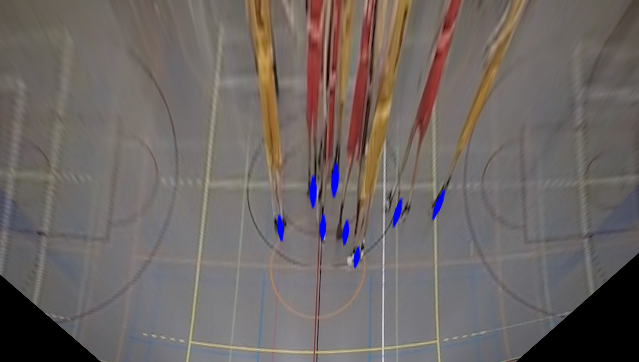

In [53]:
# Four corners of the court + mid-court circle point in destination image 
# Start top-left corner and go anti-clock wise + mid-court circle point
dst_pts = np.array([
    [43, 355],       # left bottom - bottom corner
    [317, 351],      # middle bottom corner
    [563, 351],      # right bottom - bottom corner
    [629, 293],      # right bottom - top corner
    [628, 3],        # top right rorner
    [8, 4],          # top left corner
    [2, 299]         # left bottom - top corner
    ])   

# Calculate Homography
h, status = cv2.findHomography(src_pts, dst_pts)
img_out = cv2.warpPerspective(im, h, (img_dst.shape[1], img_dst.shape[0]))
cv2_imshow(img_out)